<a href="https://colab.research.google.com/github/Bensmail-anis/Autoregressive-Character-Level-Language-Modeling/blob/main/notebooks/mlp_character_level_language_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Character-Level Language Model with Multi-Layer Perceptron (MLP)

We implements a character-level language model using a Multi-Layer Perceptron (MLP) neural network. The model learns to generate new names by predicting the next character given a sequence of previous characters. It uses PyTorch for neural network implementation and trains on a dataset of names.

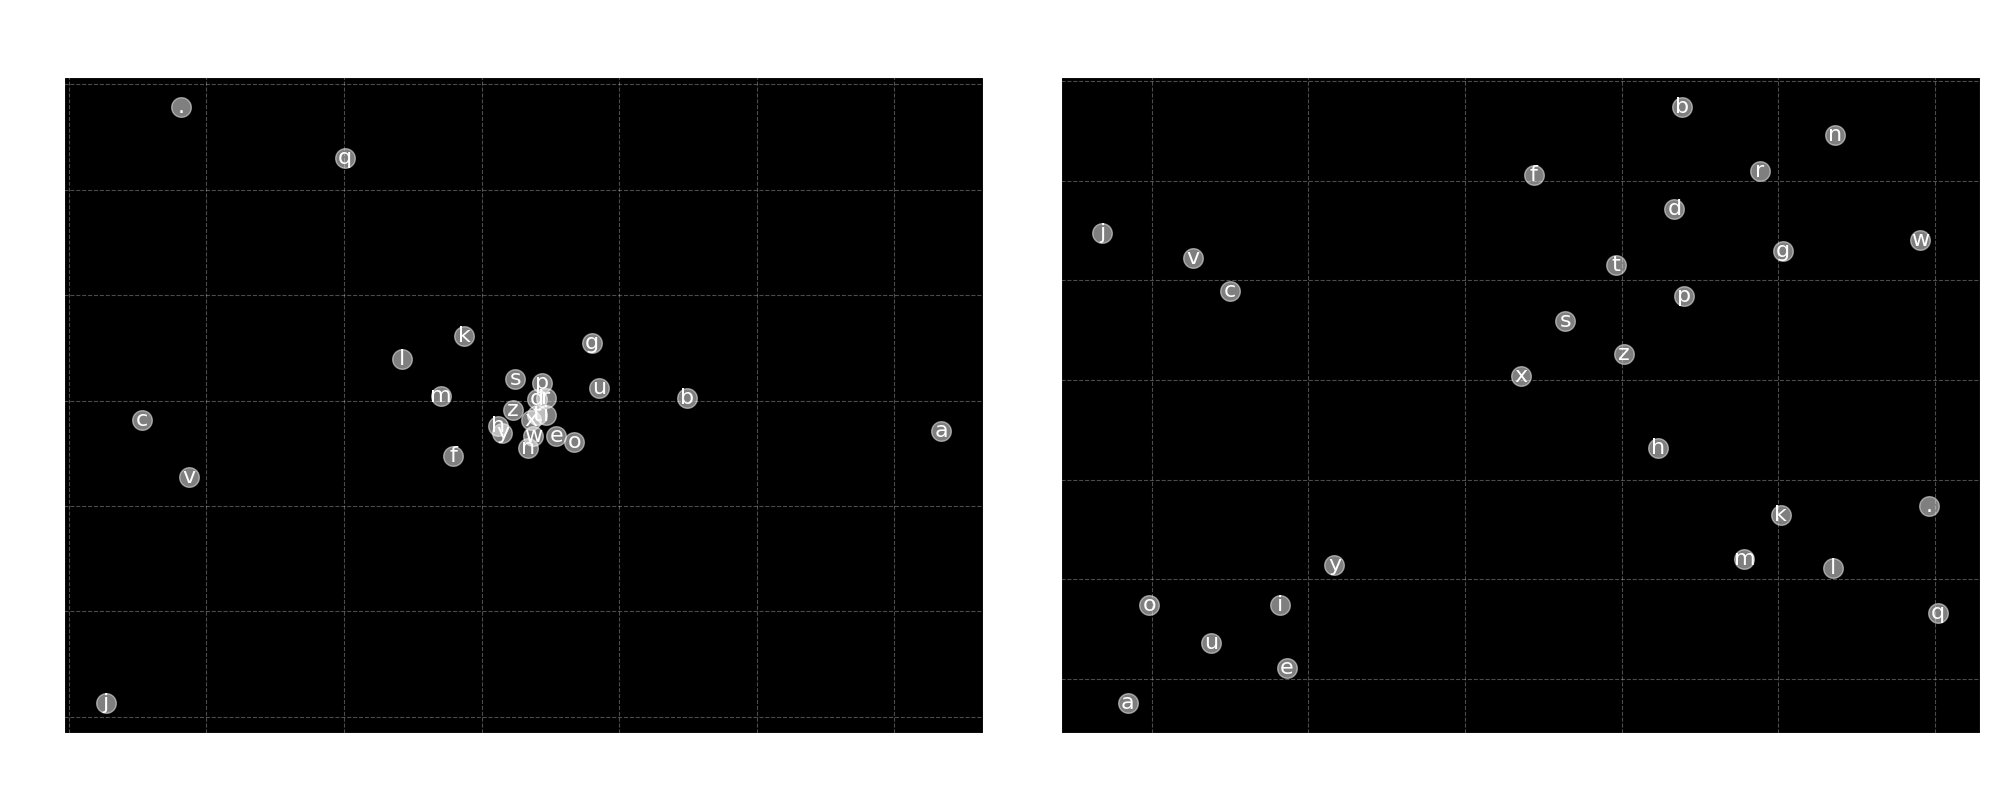

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

## Setup and Data Preparation

Character-level language models work by learning the statistical patterns between sequences of characters. The first step is to create a vocabulary of all possible characters and establish mappings between characters and their numerical representations (indices).

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


- Each character is assigned a unique integer index
- Special '.' token (index 0) marks the end of words
- Bidirectional mappings (stoi/itos) enable conversion between characters and indices

## Dataset Construction

The model learns from context windows of fixed size. For each character in a word, we create an input context (previous characters) and target (next character) pair.

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


- block_size=3 means we use 3 previous characters to predict the next one
- Dataset is split 80/10/10 for training/validation/testing
- Each input (X) is a context window of size 3
- Each target (Y) is the next character after the context

## Model Architecture

The model uses an embedding layer to convert character indices into dense vectors, followed by a feedforward neural network with one hidden layer using tanh activation.

In [6]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [7]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [8]:
for p in parameters:
  p.requires_grad = True

Important Aspects:

- Embedding dimension = 10
- Hidden layer size = 200
- Input size = 30 (3 context characters × 10 embedding dimensions)
- Output size = 27 (number of possible characters)
- All parameters are trainable (requires_grad=True)

## Training Loop

The model is trained using mini-batch gradient descent with cross-entropy loss. The learning rate is reduced halfway through training to fine-tune the parameters.

In [9]:
lri = []
lossi = []
stepi = []

In [10]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

- Batch size = 32
- Initial learning rate = 0.1
- Learning rate decay to 0.01 after 100,000 steps
- Uses manual gradient descent (no optimizer)
- CrossEntropyLoss combines softmax with negative log likelihood

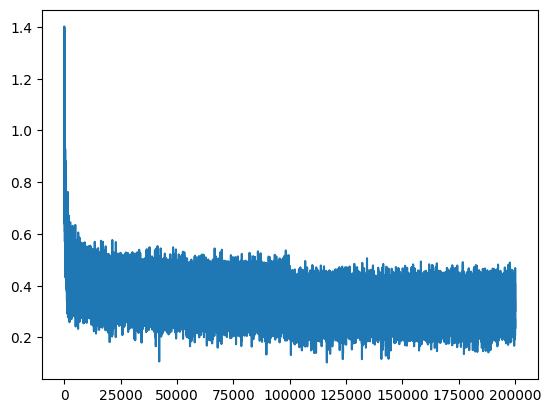

In [11]:
plt.plot(stepi, lossi)

In [12]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1320, grad_fn=<NllLossBackward0>)

In [13]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1703, grad_fn=<NllLossBackward0>)

In [14]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1725, grad_fn=<NllLossBackward0>)

- These loss values (around 2.17) are reasonable for a character-level language model:

- The values represent negative log-likelihood
- For a vocabulary of 27 characters (26 letters + end token), perfect uniform prediction would give ln(27) ≈ 3.30
- Our values being lower than this indicate the model has learned meaningful patterns


- There's still room for potential improvement through:Increasing model capacity , Adjusting hyperparameters.

## Embeddings visualization (look to the vowels together at right plot)

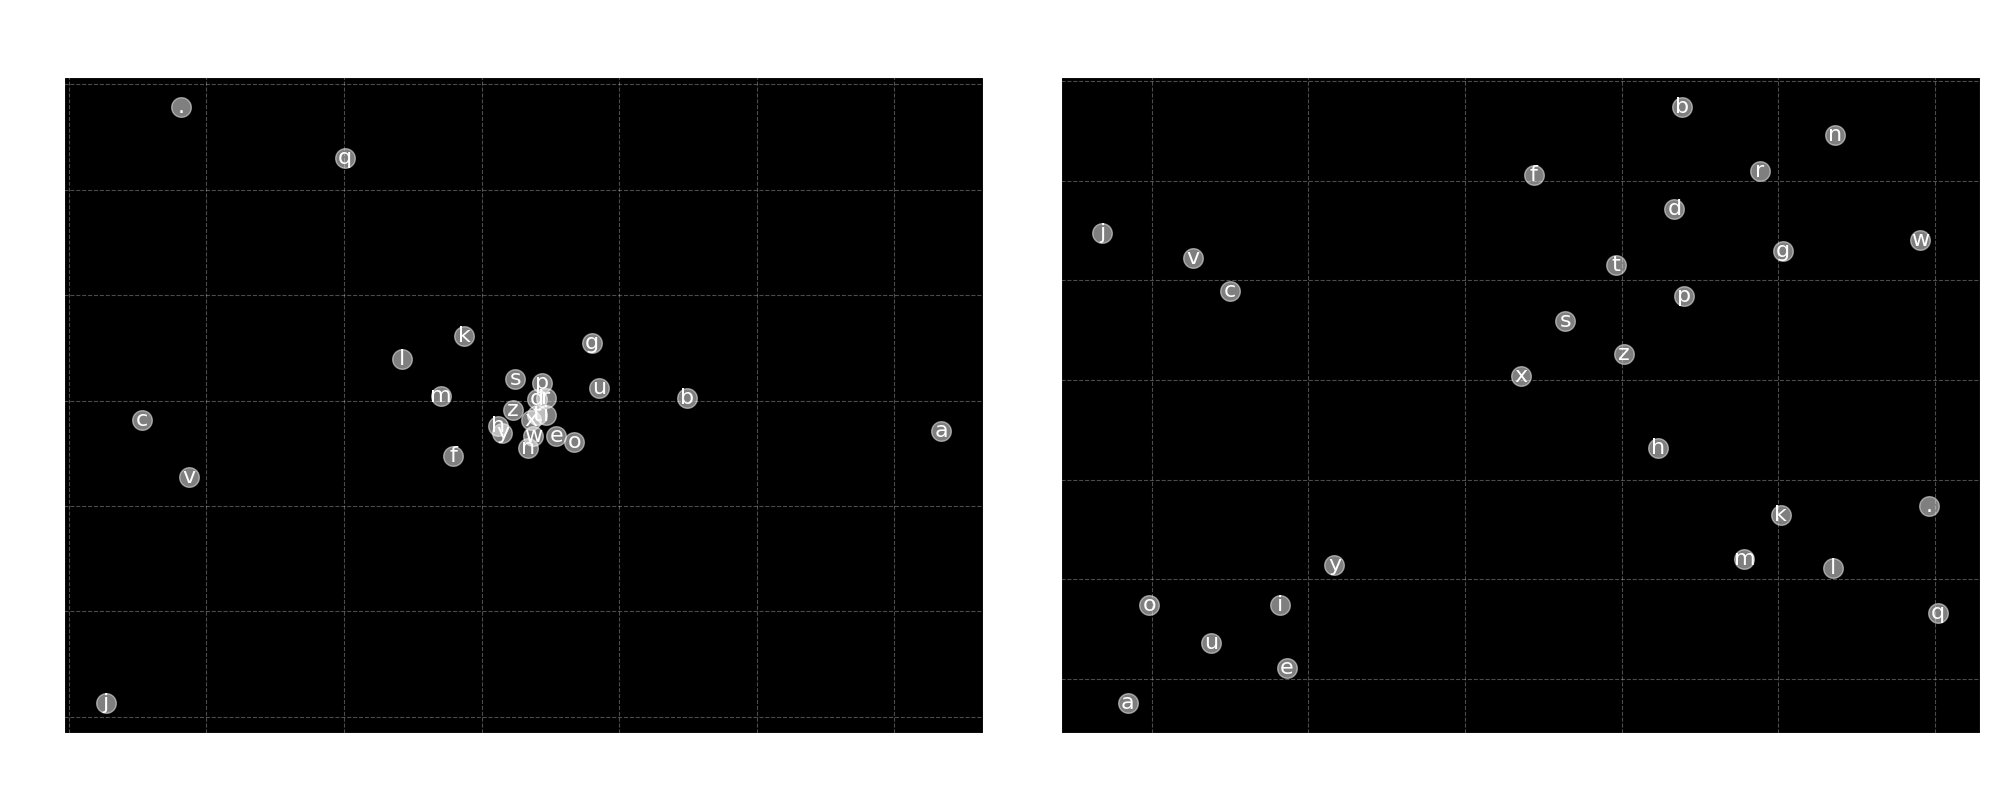


PCA Analysis:
Explained variance ratios: [0.34520388 0.19944923]
Cumulative explained variance: [0.34520388 0.5446531 ]


In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Create a figure with two subplots side by side
plt.figure(figsize=(20, 8))
plt.style.use('dark_background')

# 1. PCA Visualization
plt.subplot(1, 2, 1)
# Apply PCA to reduce from 10D to 2D
pca = PCA(n_components=2)
C_pca = pca.fit_transform(C.detach().numpy())

# Plot PCA results
plt.scatter(C_pca[:, 0], C_pca[:, 1], s=200, c='white', alpha=0.5)
for i in range(len(C_pca)):
    plt.annotate(
        itos[i],
        (C_pca[i, 0], C_pca[i, 1]),
        fontsize=16,
        color='white',
        ha='center',
        va='center'
    )
plt.grid(True, linestyle='--', alpha=0.3)
plt.title(f'PCA Visualization\nExplained Variance: {pca.explained_variance_ratio_.sum():.2%}',
          fontsize=16,
          color='white',
          pad=20)
plt.xlabel('First Principal Component', fontsize=12, color='white')
plt.ylabel('Second Principal Component', fontsize=12, color='white')

# 2. t-SNE Visualization
plt.subplot(1, 2, 2)
# Apply t-SNE to reduce from 10D to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
C_tsne = tsne.fit_transform(C.detach().numpy())

# Plot t-SNE results
plt.scatter(C_tsne[:, 0], C_tsne[:, 1], s=200, c='white', alpha=0.5)
for i in range(len(C_tsne)):
    plt.annotate(
        itos[i],
        (C_tsne[i, 0], C_tsne[i, 1]),
        fontsize=16,
        color='white',
        ha='center',
        va='center'
    )
plt.grid(True, linestyle='--', alpha=0.3)
plt.title('t-SNE Visualization\nPerplexity=5',
          fontsize=16,
          color='white',
          pad=20)
plt.xlabel('t-SNE Dimension 1', fontsize=12, color='white')
plt.ylabel('t-SNE Dimension 2', fontsize=12, color='white')

plt.tight_layout()
plt.show()

# Print additional PCA information
print("\nPCA Analysis:")
print(f"Explained variance ratios: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")

## Generation
To generate new names, we sample characters one by one using the model's probability distribution, conditioned on the previous three characters.

In [15]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

eria.
kayah.
see.
med.
ryal.
rethrus.
jerneg.
adelyn.
elin.
shi.
jenu.
keiseananar.
kateloh.
karin.
shur.
ridhiriel.
kin.
reelyn.
jetpurrius.
kaveer.


- Generation starts with empty context ([0,0,0])
- Each new character is sampled from the model's probability distribution
- Generation continues until the end token (0) is sampled
T- emperature parameter could be added to control randomness

This MLP-based character-level language model demonstrates fundamental concepts in neural language modeling while remaining simple enough to understand thoroughly. The model learns to capture local character patterns and can generate new names that often resemble those in the training set.